# Analysis of Marketing Expenses for Yandex.Afisha

Yandex.Afisha is a ticket sales service based in Russia with operations in many cities across the country.

I will go over data from 2017-2018 to help optimize marketing expenses. The data containes: server logs of user visits, details of all orders, and  marketing expenses statistics.

## Downloading and Preparing Data 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.io as pio 
pio.renderers.default = 'iframe'

There are no missing values in the data frames so I will convert the data types as I'm loading the data

In [2]:
visits = pd.read_csv('visits_log_us.csv',
                     dtype={'Device': 'category'},
                     parse_dates=['Start Ts', 'End Ts'])

orders = pd.read_csv('orders_log_us.csv',
                     parse_dates=['Buy Ts'])

expenses = pd.read_csv('costs_us.csv',
                      parse_dates=['dt'])

In [3]:
visits.describe(include='all', datetime_is_numeric=True)

,Device,End Ts,Source Id,Start Ts,Uid
count,359400,359400,359400.000000,359400,3.594000e+05
unique,2,NaN,NaN,NaN,NaN
top,desktop,NaN,NaN,NaN,NaN
freq,262567,NaN,NaN,NaN,NaN
mean,NaN,2017-12-18 06:28:15.036205056,3.750515,2017-12-18 06:17:32.010517760,9.202557e+18
min,NaN,2017-06-01 00:02:00,1.000000,2017-06-01 00:01:00,1.186350e+13
25%,NaN,2017-10-15 09:45:45,3.000000,2017-10-15 09:41:00,4.613407e+18
50%,NaN,2017-12-18 18:59:30,4.000000,2017-12-18 18:46:00,9.227413e+18
75%,NaN,2018-02-28 10:08:15,5.000000,2018-02-28 09:54:00,1.372824e+19
max,NaN,2018-06-01 01:26:00,10.000000,2018-05-31 23:59:00,1.844668e+19


In [4]:
orders.describe(include='all', datetime_is_numeric=True)

,Buy Ts,Revenue,Uid
count,50415,50415.000000,5.041500e+04
mean,2017-12-20 05:14:24.846176768,4.999647,9.098161e+18
min,2017-06-01 00:10:00,0.000000,3.135781e+14
25%,2017-10-13 17:28:00,1.220000,4.533567e+18
50%,2017-12-21 14:12:00,2.500000,9.102274e+18
75%,2018-03-02 16:10:00,4.890000,1.368290e+19
max,2018-06-01 00:02:00,2633.280000,1.844617e+19
std,NaN,21.818359,5.285742e+18


In [5]:
expenses.describe(include='all', datetime_is_numeric=True)

,source_id,dt,costs
count,2542.000000,2542,2542.000000
mean,4.857199,2017-11-29 09:04:57.403619072,129.477427
min,1.000000,2017-06-01 00:00:00,0.540000
25%,2.000000,2017-08-30 00:00:00,21.945000
50%,4.000000,2017-11-29 00:00:00,77.295000
75%,9.000000,2018-02-28 00:00:00,170.065000
max,10.000000,2018-05-31 00:00:00,1788.280000
std,3.181581,NaN,156.296628


## Calculating Metrics

In order to calculate metrics I will first create necessary data columns.

In [6]:
visits['session_year'] = visits['Start Ts'].astype('datetime64[Y]')
visits['session_month'] = visits['Start Ts'].astype('datetime64[M]').dt.date
visits['session_week'] = visits['Start Ts'].astype('datetime64[W]').dt.date
visits['session_date'] = visits['Start Ts'].astype('datetime64[D]').dt.date
visits['session_length'] = abs(visits['End Ts'] - visits['Start Ts']).astype('timedelta64[m]')

visits.head(2)

,Device,End Ts,Source Id,Start Ts,Uid,session_year,session_month,session_week,session_date,session_length
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,28.0


### Product

#### User Activity

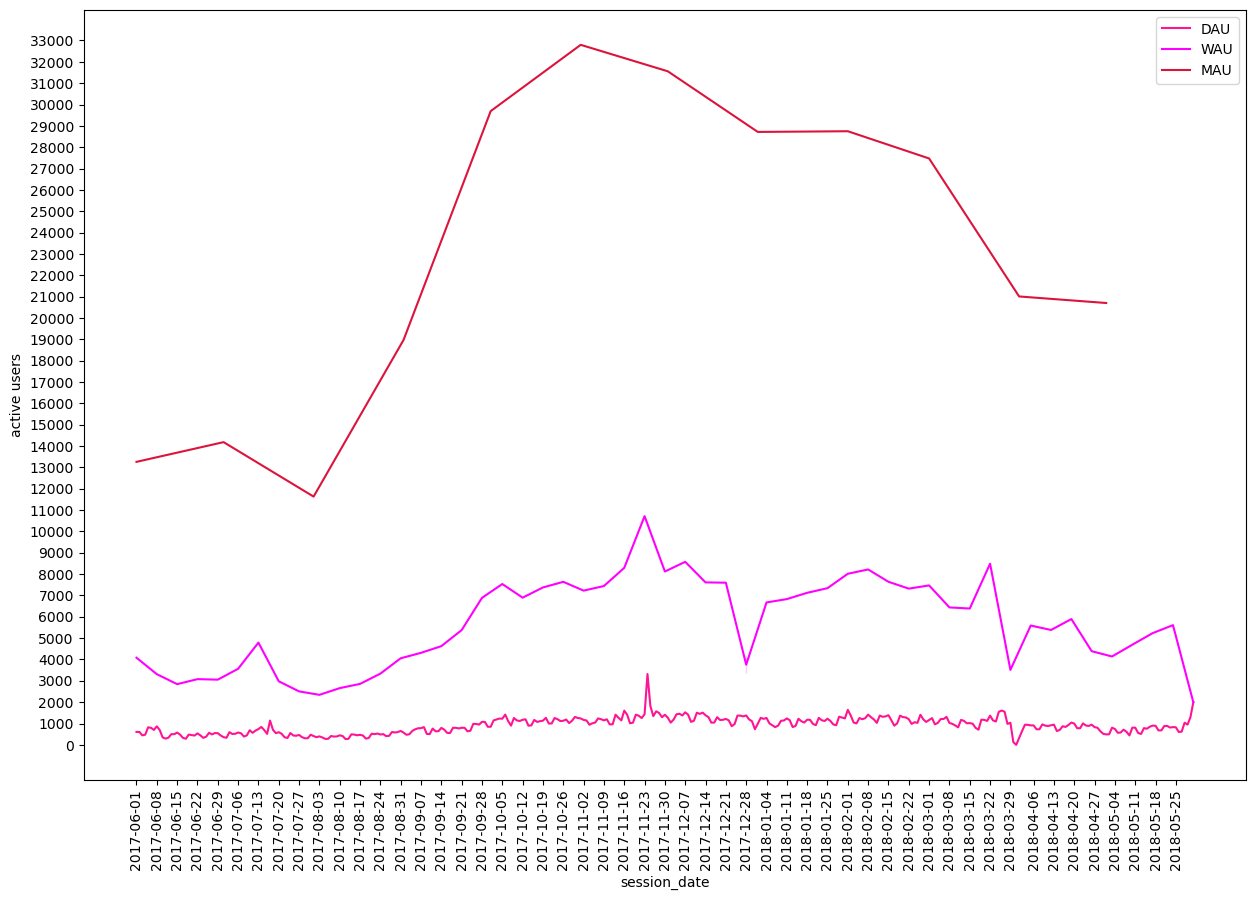

Overall average active users
Daily: 907
Weekly: 5621
Monthly: 23228


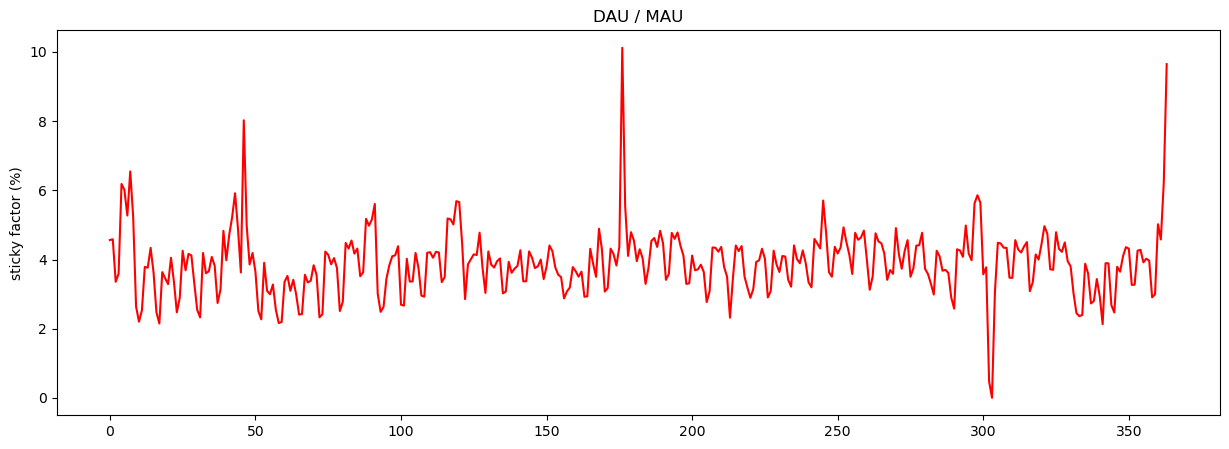

Average sticky factor: 3.89


In [10]:
dau = visits.groupby('session_date').agg({'Uid': 'nunique'}).reset_index()
wau = visits.groupby(['session_year', 'session_week']).agg({'Uid': 'nunique'}).reset_index()
mau = visits.groupby(['session_year', 'session_month']).agg({'Uid': 'nunique'}).reset_index()

plt.figure(figsize = (15,10))
ax = sns.lineplot(x='session_date', y='Uid', data=dau, label='DAU', color='deeppink')
sns.lineplot(x='session_week', y='Uid', data=wau, label='WAU', color='magenta')
sns.lineplot(x='session_month', y='Uid', data=mau, label='MAU', color='crimson')
ax.set_xticks(dau['session_date'][::7])
ax.set_xticklabels(dau['session_date'][::7],rotation=90)
ax.set_yticks(range(0,33500,1000))
plt.ylabel('active users')
plt.show()

print('Overall average active users')
print('Daily:', int(dau.Uid.mean()))
print('Weekly:', int(wau.Uid.mean()))
print('Monthly:', int(mau.Uid.mean()))

dau['session_month'] = dau['session_date'].astype('datetime64[M]').dt.date
stfactor = pd.merge(dau, mau, on='session_month')
stfactor['sticky_factor'] = (100*(stfactor['Uid_x'] / stfactor['Uid_y']))
plt.figure(figsize=(15,5))
plt.plot(stfactor['sticky_factor'], color='red')
plt.ylabel('sticky factor (%)')
plt.title('DAU / MAU')
plt.show()
print('Average sticky factor:', round(stfactor['sticky_factor'].mean(),2))

There is a peak im user activity during September until April. Suggesting a seasonality to user activity- people preffer attending indoor activities during the winter months rather then during the summer.

From the daily active users plot, we can see there are spikes in user activity on specific days around the end of the month, specifficaly there is a big peak on the 24.11.17, This suggests a corolation between special events and user activity- a new show, a holiday, or paycheck time. There is practicaly no user activity on the 31.3.18, this could be because the site was closed temporarly.

Stickeyness factor dosen't vary that much, except for peak days, but this is probably due to dau being higher then mau on those days. There is also a dip from the low dau day.

#### Daily Sessions

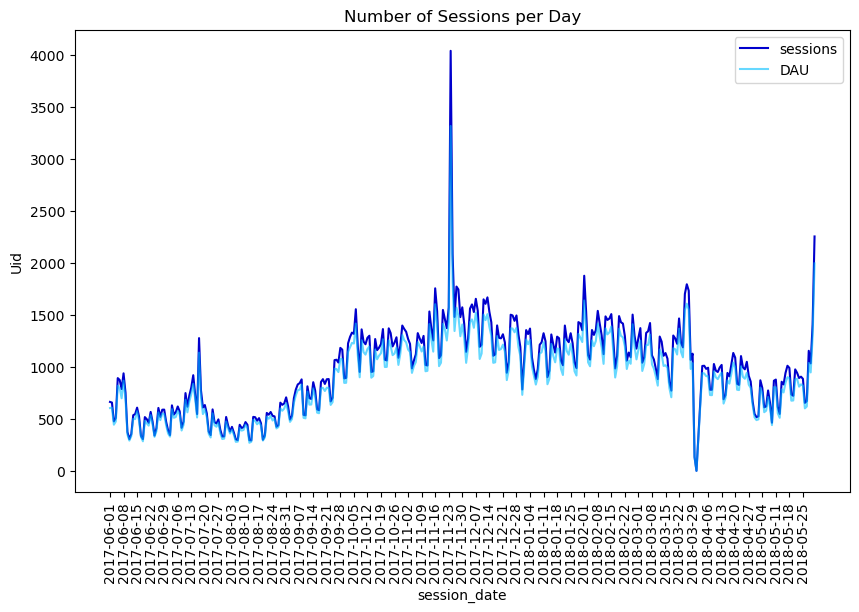

Average number of sessions per day: 987


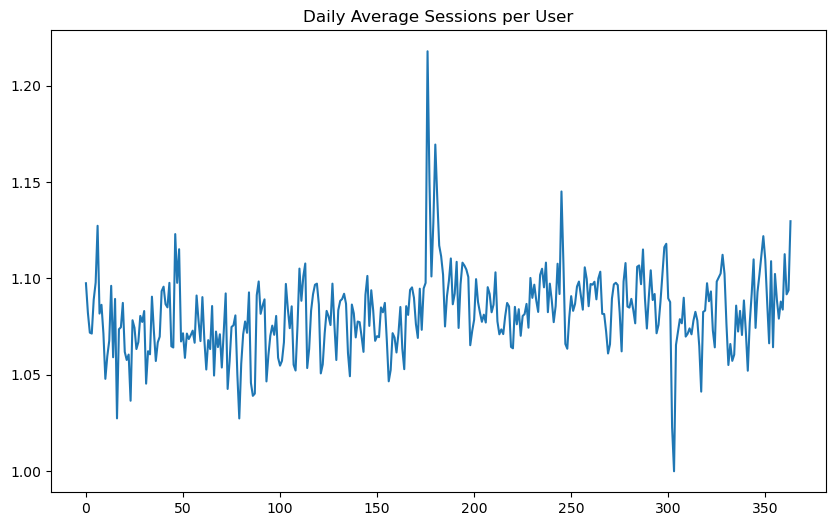

Average number of sessions per user: 1


In [11]:
sess_per_day = visits.groupby('session_date').agg({'Uid': 'count'}).reset_index()
plt.figure(figsize = (10,6))
ax = sns.lineplot(x='session_date', y='Uid', data=sess_per_day, label= 'sessions', color='mediumblue')
sns.lineplot(x='session_date', y='Uid', data=dau, label='DAU', color='deepskyblue', alpha=0.6)
ax.set_xticks(sess_per_day['session_date'][::7])
ax.set_xticklabels(sess_per_day['session_date'][::7],rotation=90)
plt.title('Number of Sessions per Day')
plt.show()
print('Average number of sessions per day:', int(sess_per_day.mean(numeric_only=True)))

avg_per_user = sess_per_day['Uid'] / dau['Uid']
plt.figure(figsize = (10,6))
plt.plot(avg_per_user)
plt.title('Daily Average Sessions per User')
plt.show()
print('Average number of sessions per user:', int(avg_per_user.mean()))

Number of daily sessions dosen't differ much from dau, this is because users tipically have 1 session per visit.

Average number of sessions per day on: touch : 266
Average number of sessions per day on: desktop : 721


C:\Users\mayah\AppData\Local\Temp\ipykernel_29528\3190183902.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\mayah\AppData\Local\Temp\ipykernel_29528\3190183902.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



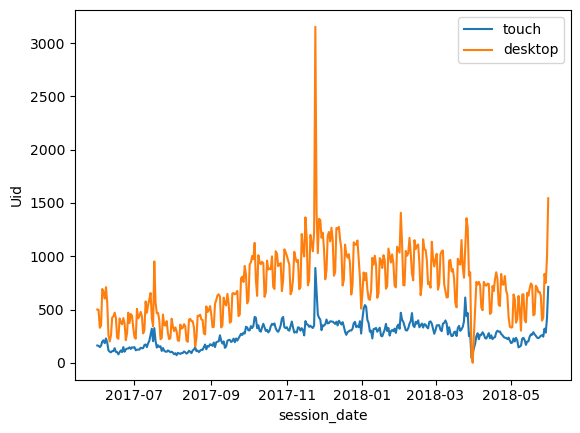

In [12]:
def num_sessions(device): 
    sess = visits[visits['Device'] == device].groupby('session_date').agg({'Uid': 'count'}).reset_index()
    sns.lineplot(x='session_date', y='Uid', data=sess, label=device)
    print('Average number of sessions per day on:', device, ':', int(sess.mean()))
    
for device in visits['Device'].unique():
    num_sessions(device)

There are overall less users who use the service on touch devices then on desktop device. The dynamics of number of sessions dosen't change between general to diffrent devices.

#### Length of Sessions

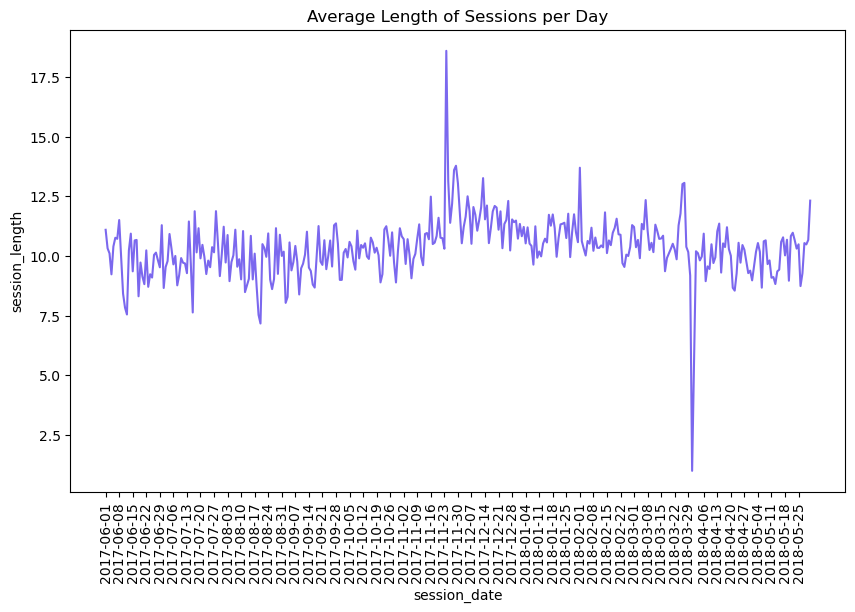

Average session length: 10 minutes


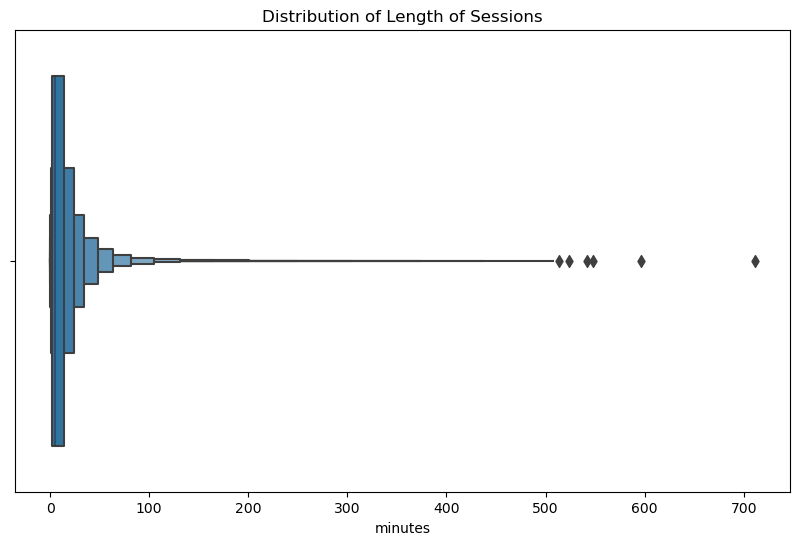

Most common length of session: 1 minutes


In [13]:
length_sess_per_day = visits.groupby('session_date').agg({'session_length': 'mean'}).reset_index()
plt.figure(figsize = (10,6))
ax = sns.lineplot(x='session_date', y='session_length', data=length_sess_per_day, color='mediumslateblue')
ax.set_xticks(length_sess_per_day['session_date'][::7])
ax.set_xticklabels(length_sess_per_day['session_date'][::7],rotation=90)
plt.title('Average Length of Sessions per Day')
plt.show()
print('Average session length:', int(length_sess_per_day.mean(numeric_only=True)), 'minutes')

plt.figure(figsize=(10,6))
sns.boxenplot(x=visits['session_length'])
plt.xlabel('minutes')
plt.title('Distribution of Length of Sessions')
plt.show()
print('Most common length of session:', int(visits['session_length'].mode()), 'minutes')

The average length of sessions varies less then the number of daily sessions, suggesting that users tend to spend around the same amount of time on the serivice platform, although the peak in number of sessions on 24.11.17 also corolates to a peak in average session length, indicating users were not only more frequent but spentmore time on the platform. The dip in average session length corolates the dip in user activity on the 31.3.18 from the platform maybe being down.

From the distribution of session lengths we can see that the majority of sessions are less then the average (10 minutes) and most users spend just 1 minute on the platform, while there are few very long sessions.
Reasons for the long sessions might be, that the user had left the device with the service window open, or they were reading descriptions of events, or the window was left open after the order had been made.
The short sessions are probably due to most users knowing what they want to order before opening the service and then they complete the order quickly.

Average session length on: touch : 7 minutes


C:\Users\mayah\AppData\Local\Temp\ipykernel_29528\1017933285.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.

C:\Users\mayah\AppData\Local\Temp\ipykernel_29528\1017933285.py:4: FutureWarning:

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.



Average session length on: desktop : 11 minutes


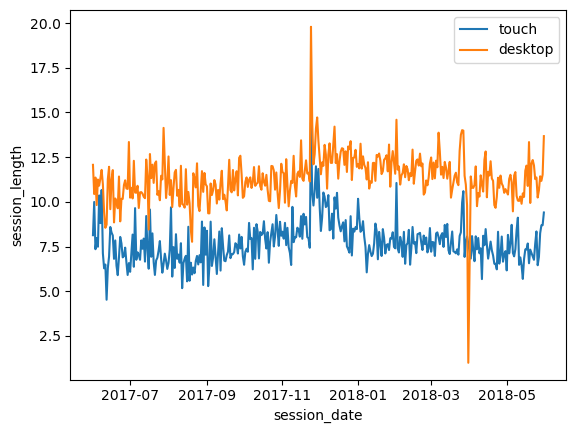

In [14]:
def length(device): 
    sess_len = visits[visits['Device'] == device].groupby('session_date').agg({'session_length': 'mean'}).reset_index()
    sns.lineplot(x='session_date', y='session_length', data=sess_len, label=device)
    print('Average session length on:', device, ':', int(sess_len.mean()), 'minutes')
    
for device in visits['Device'].unique():
    length(device)

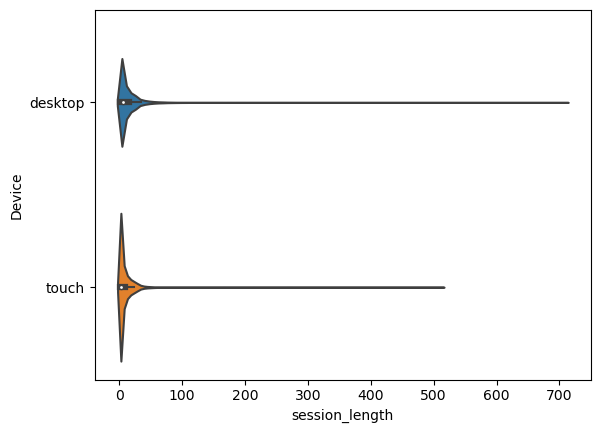

Most common length of session:
on desktop: 1 minutes
on touch: 1 minutes


In [15]:
sns.violinplot(x='session_length', y='Device', data=visits, split=True)
plt.show()
print('Most common length of session:')
print('on desktop:', int(visits.query('Device == "desktop"')['session_length'].mode()), 'minutes')
print('on touch:', int(visits.query('Device == "touch"')['session_length'].mode()), 'minutes')

Users using touch devices have shorter sesssioms more often then desktop users. this could be because they are less likely to leave unactive windows open for a very long time, or that when ordering on touch device it takes less time, or the user demograpic is diffrent (by age maybe) between device types.

#### Retention Rate

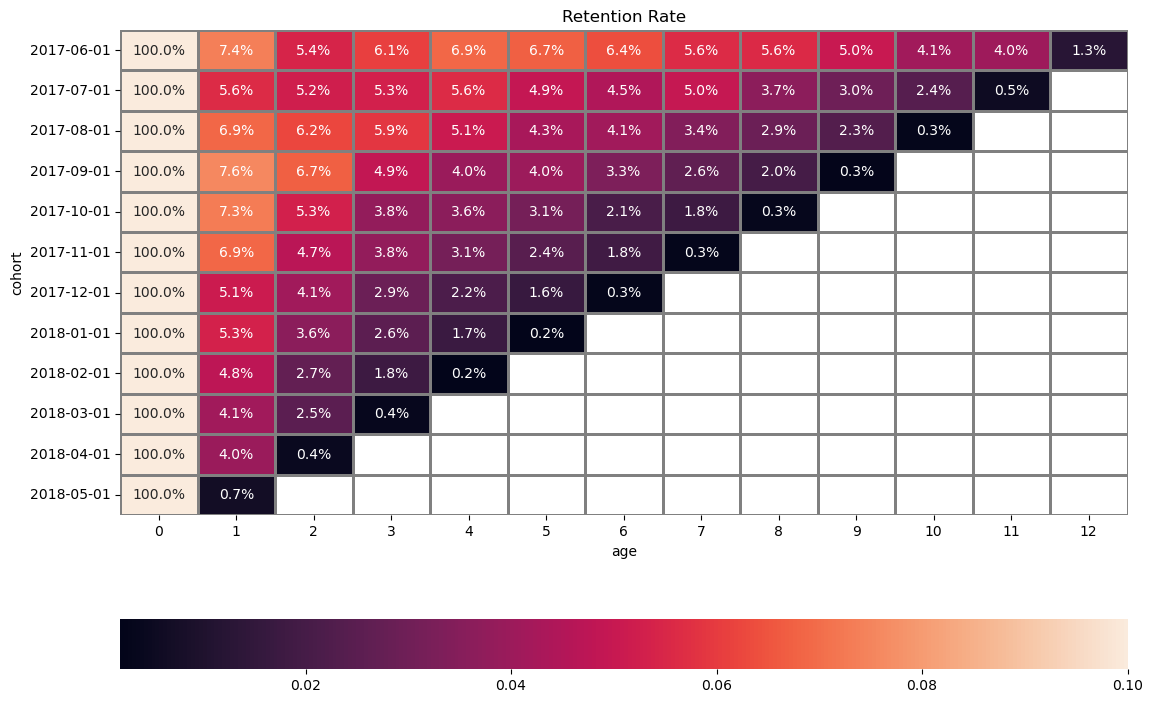

In [16]:
visits1 = visits.copy()
first_activity_date = visits1.groupby(['Uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'
visits1 = visits1.join(first_activity_date, on='Uid')
visits1['age'] = ((visits1['session_date'] - visits1['first_activity_date'])/np.timedelta64(1, 'M')).round().astype(int)
visits1['cohort'] = visits1['first_activity_date'].astype('datetime64[M]').dt.date
cohorts = visits1.pivot_table(index='cohort', columns='age',
                              values='Uid', aggfunc='nunique')
retention = cohorts.iloc[:,0:].div(cohorts[0], axis=0)
plt.figure(figsize=(13,9))
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='grey',  vmax=0.1, cbar_kws= {'orientation': 'horizontal'} 
            ).set(title = 'Retention Rate')
plt.show()

Users tend to come back more often when they started using the service in summer months, probablt due to the fact that winter months have a higher user activity in general.
We can see that for every cohort there is the highest retention rate in the winter months. 
June, August, and September cohorts habe the highest retention rates overall and over time.

### Sales

#### Conversion rate

In [19]:
orders1 = orders.copy()
first_order = orders.groupby('Uid')['Buy Ts'].min()
first_order.name = 'first_order'
orders1 = orders1.merge(first_activity_date, on='Uid', how='left')
orders1 = orders1.merge(first_order, on='Uid', how='left')
orders1['conversion'] = ((orders1['first_order'].dt.date - orders1['first_activity_date'])/np.timedelta64(1, 'D')).astype(int)
fig = px.histogram(orders1, x="conversion",nbins=30)
fig.show()

print('Average number of days it takes to convert is', round(orders1['conversion'].mean(),1))
print('Most users convert at day', orders1['conversion'].mode().max())
print('The overall conversion rate is {:.1%}'.format(orders1['Uid'].nunique()/visits['Uid'].nunique()))

Average number of days it takes to convert is 17.6
Most users convert at day 0
The overall conversion rate is 16.0%


Coversion mostly happens on the day of the first visit. Some users take a very long time to make a first order, this could be due to seasonality- they visit the service in the summer but only make an order during winter.

#### Orders by Cohorts

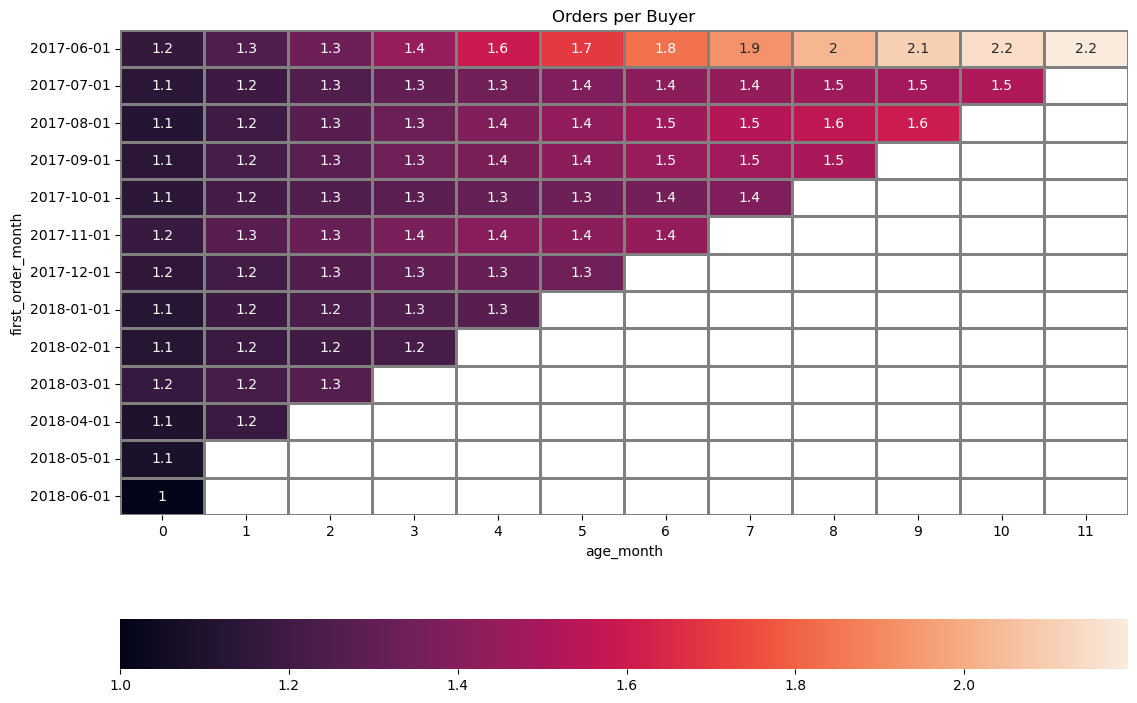

In [20]:
orders2 = orders1.copy()
orders2['order_month'] = orders2['Buy Ts'].astype('datetime64[M]').dt.date
orders2['first_order_month'] = orders2['first_order'].astype('datetime64[M]').dt.date
cohort_sizes = orders2.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns=['first_order_month','cohort_size']
cohort=orders2.groupby(['first_order_month','order_month'])['Revenue'].count().reset_index()
cohort.columns=['first_order_month','month','orders']
cohort=cohort.merge(cohort_sizes,on=['first_order_month'])
cohort['age_month'] = ((cohort['month'] - cohort['first_order_month']) / np.timedelta64(1,'M')).round().astype(int)
cohort['orders_per_buyer']=cohort['orders']/cohort['cohort_size']
cohort_piv=cohort.pivot_table(index='first_order_month', columns='age_month', 
                              values='orders_per_buyer', aggfunc='sum').cumsum(axis=1)
cohort_piv.round(2).fillna('')
plt.figure(figsize=(13,9))
sns.heatmap(cohort_piv, annot=True, linewidths=1, linecolor='grey', cbar_kws= {'orientation': 'horizontal'} 
            ).set(title = 'Orders per Buyer')
plt.show()

As the cohorts age, retention rate goes down and users make less orders.
The June cohort is most succefull in orders per buyer over time, then the August cohort.

#### Average purchase size

In [25]:
avg_check=orders.groupby(['Uid'])['Revenue'].sum().reset_index()
fig = px.histogram(avg_check, x='Revenue')
fig.show()
print('Overall average revenue per user:', round(avg_check['Revenue'].mean(),2))
print('Most commen revenue per user:', round(float(avg_check['Revenue'].mode()),2))

Overall average revenue per user: 6.9
Most commen revenue per user: 2.44


Majority of purchases are small, while very few users have large purchases. This is probably because most users buy a few tickets a few times (occasionally for themselves and maybe friends or family), some users buy alot of tickets a few times (occasionally for a group outing), some users buy a few tickets alot of times (often for themselves and friends), and a few buy alot of tickets alot of times (often for a group), and a smaller few might buy alot of tickets and resell them.

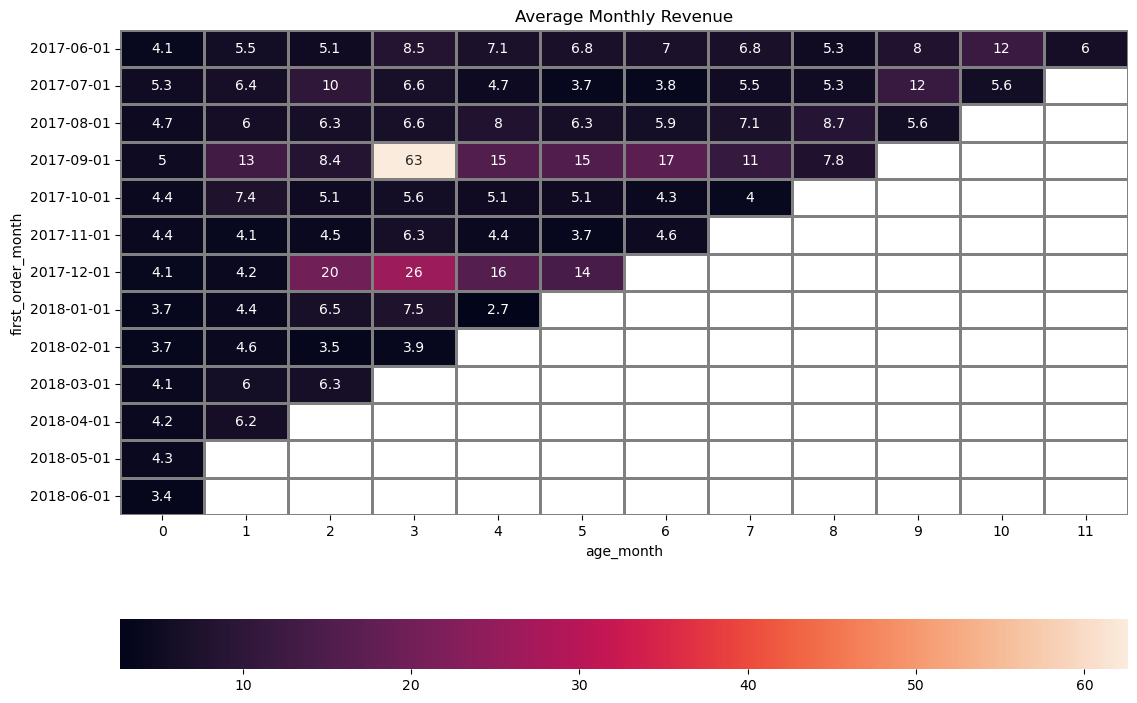

In [26]:
avg_cohort=orders2.groupby(['first_order_month','order_month'])['Revenue'].mean().reset_index()
avg_cohort['age_month'] = ((avg_cohort['order_month'] - avg_cohort['first_order_month']) / np.timedelta64(1,'M')).round().astype(int)
avg_cohort_piv=avg_cohort.pivot_table(index='first_order_month', columns='age_month', 
                                      values='Revenue', aggfunc='mean')
avg_cohort_piv.round(2).fillna('')
plt.figure(figsize=(13,9))
sns.heatmap(avg_cohort_piv, annot=True, linewidths=1, linecolor='grey', cbar_kws= {'orientation': 'horizontal'} 
            ).set(title = 'Average Monthly Revenue')
plt.show()

Most average monthly revenue is between the most commen average revenue per buyer (2.44) and the overall average revenue per buyer (6.9). 
The September cohort is the best in terms of average monthly revenue, with high values throughout the winter months, after that the December cohort was the best, with high values throughout spring months.
April month has high values in most cohorts (relativly). 
Overall highest value is in December for September cohort.

There is no obviouse corrolation between average monthly revenue and average monthly orders per buyer.
There is no obviouse corrolation between seasonality of user activity and average monthly revenue. 

The cohorts that were most succesfull in terms of user activity aren't the most succesfull in terms of monthly revenue, this could be because most users make small order and a few make very large orders. Cohorts with high user activity have more small order users and other cohorts attract large order users.


#### LTV

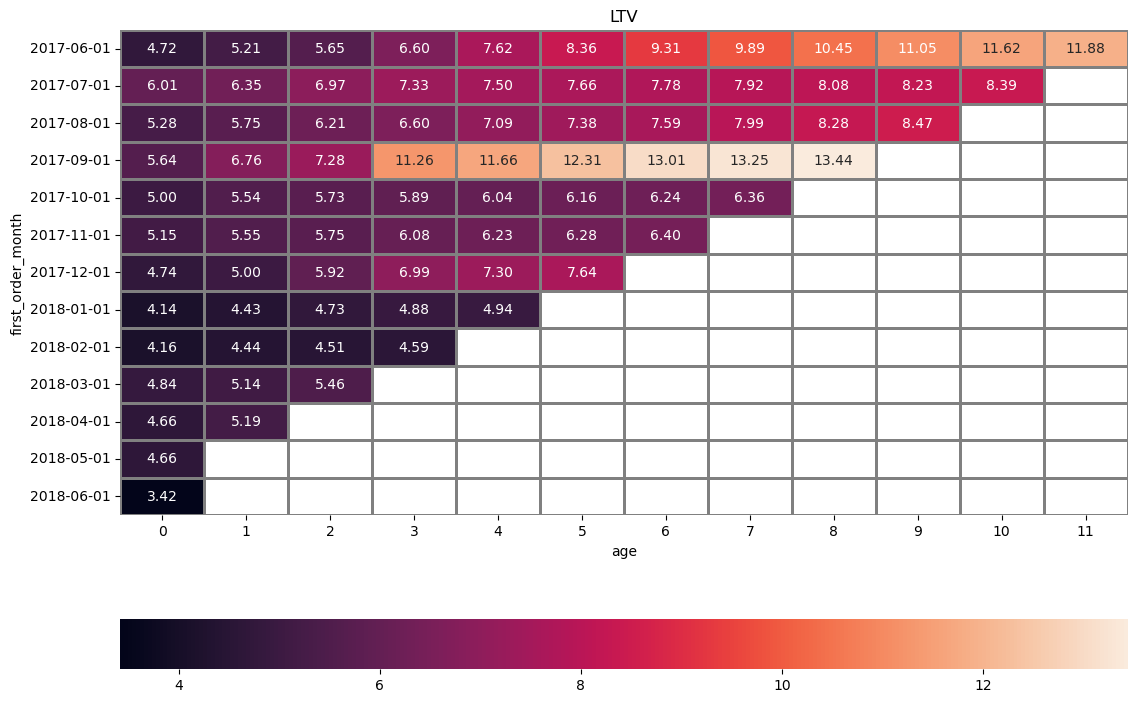

In [27]:
orders3 = orders2.copy()
ltv_cohort=orders3.groupby(['first_order_month','order_month'])['Revenue'].sum().reset_index()
ltv_cohort.columns = ['first_order_month','month','revenue']
ltv_cohort=ltv_cohort.merge(cohort_sizes,on=['first_order_month'])
ltv_cohort['age']=((ltv_cohort['month'] - ltv_cohort['first_order_month']) / np.timedelta64(1,'M')).round().astype(int)
ltv_cohort['ltv']=ltv_cohort['revenue']/ltv_cohort['cohort_size']
ltv_cohort_piv=ltv_cohort.pivot_table(index='first_order_month', columns='age', 
                                      values='ltv', aggfunc='sum').cumsum(axis=1)
plt.figure(figsize=(13,9))
sns.heatmap(ltv_cohort_piv, annot=True, fmt='.2f', linewidths=1, linecolor='grey', cbar_kws= {'orientation': 'horizontal'} 
            ).set(title ='LTV')
plt.show()

There is a seasonality to average revenue per user, high values during winter months (including April and May). This is a combination of high user activity during winter months and high monthly revenue during spring.

September cohort was the most succesfull in terms of LTV, this is probably due to the high monthly revenues it has. after that the June cohort is good, probably due to high retention rate and high orders per buyer. December cohort has relativly high values during spring, also due to high monthly revenue.

### Marketing

#### Money Spent

In [28]:
expenses=expenses.sort_values(by=['dt','source_id'])
fig = px.line(expenses, x="dt", y="costs", color='source_id')
fig.show()
print('Total marketing cost is {}'.format(expenses['costs'].sum()))

Total marketing cost is 329131.62


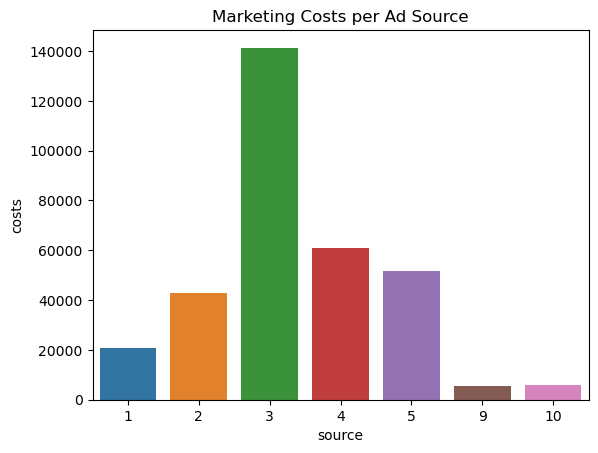

In [29]:
marketing_per_source=expenses.groupby('source_id')['costs'].sum().reset_index()
marketing_per_source.columns=['source','costs']
sns.barplot(x='source',y='costs', data=marketing_per_source)
plt.title('Marketing Costs per Ad Source')
plt.show()

There are higher marketing expenses during winter months- corolating to high user activity. There is a peak in marketing costs during end of November wich corolates to a peak in user activity. Revenue peaks during winter and spring, when marketing costs are ongoing on high and as they go down (as a result of the marketing efforts).

Marketing costs are not split evenly by ad source. 
Ad source 3 has the highest marketing costs, after that 4, then 5, then 2, then 1, then 9 and 10.

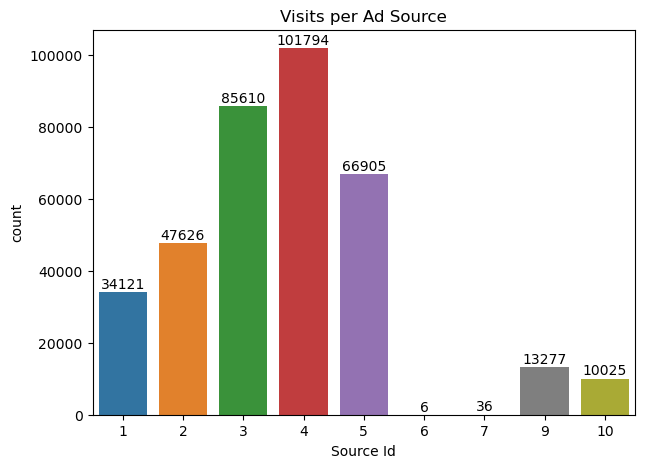

In [30]:
plt.figure(figsize=(7, 5))
sns.countplot(x='Source Id', data=visits)
plt.title('Visits per Ad Source')
for source in visits['Source Id'].unique():
    plt.text(x=(source-1 if source < 9 else source-2), 
             y=visits['Source Id'].value_counts()[source] + 1050, 
             s=visits['Source Id'].value_counts()[source],
            horizontalalignment='center')

Ad source 4 attracts the most visitors, then 3, after that amount of visitors per source is corolated to marketing costs per source. Ad sources 6 and 7 do not have a marketing budget and attract a very small amount of users.

#### CAC 

In [33]:
expenses['cost_month']=expenses['dt'].astype('datetime64[M]').dt.date
marketing_by_month=expenses.groupby(['cost_month'])['costs'].sum().reset_index()
buyers_per_month=orders2.groupby(['first_order_month'])['Uid'].nunique().reset_index()
buyers_per_month.columns=['cost_month','buyers']
CAC_per_month=marketing_by_month.merge(buyers_per_month,how='left',on=['cost_month'])
CAC_per_month['CAC']=CAC_per_month['costs']/CAC_per_month['buyers']
fig = px.line(CAC_per_month, x="cost_month", y="CAC", title='CAC')
fig.show()
print('Overall average CAC:', round(CAC_per_month['CAC'].mean(),2))

Overall average CAC: 9.15


Cost of customer aquisition is highest in August and lowest in May.
This is corrolated to wthe effects of marketing efforts, August is at the end of low marketing costs period and has low user activity, May is at the end of high marketing costs period and has somewhat high user activity.
Overall average cac is higher then overall average revenue per user.

In [35]:
orders3 = orders2.copy()
first_source=visits.sort_values('Start Ts').groupby('Uid').first()['Source Id']
first_source.name='first_source'
orders3=orders3.merge(first_source,on=['Uid'],how='left')
marketing_by_month_source=expenses.groupby(['cost_month','source_id'])['costs'].sum().reset_index()
buyers_per_month_source=orders3.groupby(['first_order_month','first_source'])['Uid'].nunique().reset_index()
buyers_per_month_source.columns=['cost_month','source_id','buyers']
CAC_per_month_source=marketing_by_month_source.merge(buyers_per_month_source,how='left',on=['cost_month','source_id'])
CAC_per_month_source['CAC']=CAC_per_month_source['costs']/CAC_per_month_source['buyers']
fig = px.line(CAC_per_month_source, x="cost_month", y="CAC",color='source_id',title='CAC')
fig.show()

print('Overall average CAC per source:')
for source in CAC_per_month_source['source_id'].unique():
    print(source, ':', round(CAC_per_month_source[CAC_per_month_source['source_id'] == source]['CAC'].mean(),2))

Overall average CAC per source:
1 : 7.21
2 : 12.5
3 : 13.8
4 : 6.44
5 : 7.45
9 : 5.41
10 : 4.87


The dynamics of customer aquisition costs aren't the same over ad sources. 
Ad source 3 has the highest customer aquisition costs, followed by ad source 2.
Peaks in cac for ad sources 3 and 4 (the sources with the highest marketing costs) corolate to the peak in general cac.

#### ROI

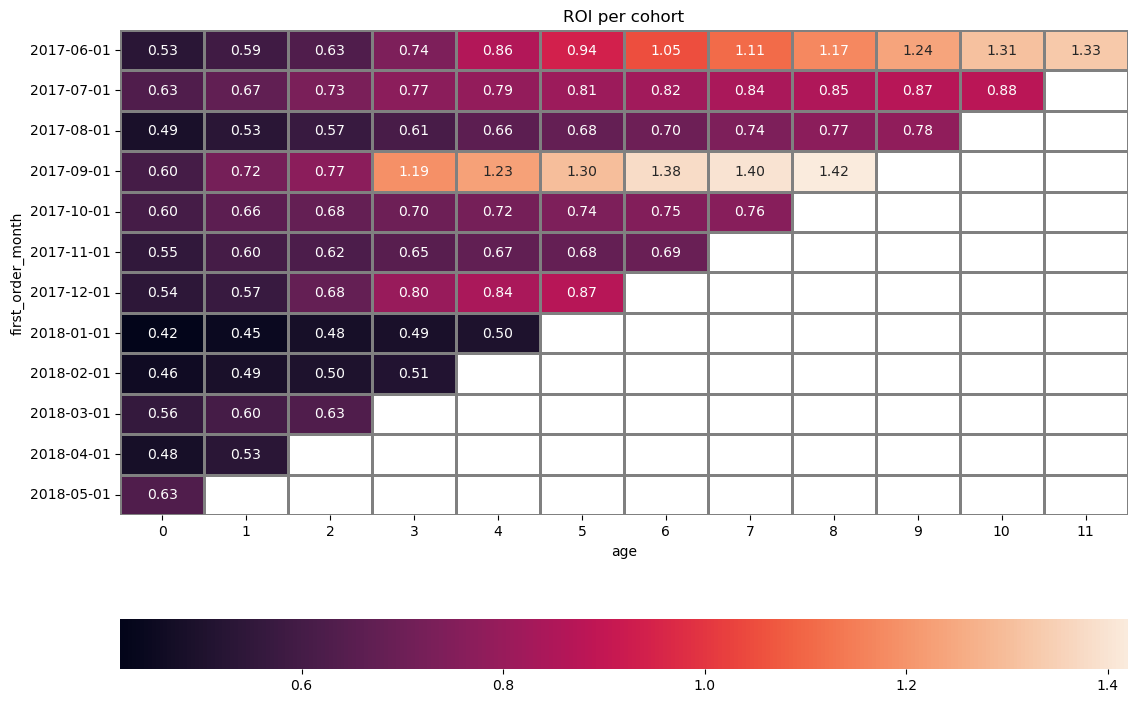

In [36]:
CAC_per_month_ROI=CAC_per_month[['cost_month','CAC']]
CAC_per_month_ROI.columns=['first_order_month','CAC']
ROI=ltv_cohort.merge(CAC_per_month_ROI,on=['first_order_month'],how='left')
ROI['ROI']=ROI['ltv']/ROI['CAC']
roi_piv = ROI.pivot_table(index='first_order_month', columns='age', 
                          values='ROI', aggfunc='mean').cumsum(axis=1).round(2)
plt.figure(figsize=(13,9))
sns.heatmap(roi_piv, annot=True, fmt='.2f', linewidths=1, linecolor='grey', cbar_kws= {'orientation': 'horizontal'} 
            ).set(title ='ROI per cohort')
plt.show()

Return of investment is highest in winter-spring. September, then June, then December, are most sucessfull in terms of ROI. There is a strong corolation between revenue per customer and return of investmemt.
Not all cohorts pay back thier investment (make profit).

In [37]:
ltv_per_source=orders3.groupby('first_source')[['Uid','Revenue']].agg({'Uid':'nunique','Revenue':'sum'}).reset_index()
ltv_per_source.columns=['source','buyers','revenue']
ltv_per_source['ltv']=ltv_per_source['revenue']/ltv_per_source['buyers']
roi_per_source=marketing_per_source.merge(ltv_per_source,on=['source'])
roi_per_source['cac']=roi_per_source['costs']/roi_per_source['buyers']
roi_per_source['romi']=roi_per_source['ltv']/roi_per_source['cac']
fig = px.bar(roi_per_source, x='source', y='romi')
fig.update_xaxes(type='category')
fig.show()

Return on marketing investment is highest for source 1 and lowest for source 3.
Source 3 is taking up to much of the marketing costs without being very fruitfull.
Source 1 can take up more share of marketing costs. 

## Conclusions

○ There is seasonality in user activity- low traffic during summer and high traffic in winter. User activity can also spike during special days.

○ Users tend to have 1 session that is 1 minute long. Some users have very long sessions bringing the average length to 10 min. Team should look into the reasons for long sessions and how they corolate to revenue.

○ There are less touch device users then desktop device users, dynamics are similiar for both. Fewer users on touch device, compared to desktop, have very long sessions. Team should look into improving the app.

○ Retention rate is higher for cohorts of the winter months, and in the beggining of cohort lifetimes. June cohort is succsefull in terms of retention rate.

○ Majority of users convert on thier first visit. Number of orders is higher in winter months. Number of orders made per cohort decresses as users stop using the service over time. June cohort is sussecfull in terms of amount of orders.

○ Most users make small orders, while a few users make very large orders. Team should investigate demographic of large orders and also corolation to other metrics.

○ Average monthly revenue is high during winter and spring, specifically high in April. September and December cohorts are succesfull in terms of monthly revenue.

○ Fall cohorts have better revenue per buyer over time. September cohort is succesfull in terms of revenue per buyer.

○ Ad source 4 brings the most users, ad source 1 has the highest return on investment. June and September cohorts have the best return on investment.

○ Ad source 3 has the highest marketing costs and lowest return on investment, it should be droped and the money invested in ad source 1 instead.